<a href="https://colab.research.google.com/github/Lesiazhou/QM2/blob/main/ndvi_difference_in_differences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing required libraries

In [ ]:
%%capture
!pip install Basemap
!pip install basemap-data-hires
!pip install ipyleaflet

In [ ]:
import ee
import pandas as pd
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (8, 8)
import seaborn as sns
import plotly
import plotly.express as px
import warnings
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col
warnings.filterwarnings('ignore')
sns.set(font_scale=1)
sns.set_style("white")

# Convert to dataframe

In [ ]:
df = pd.read_csv('https://storage.googleapis.com/sample-bucket-qm2/ndvi.csv').drop(columns=['Unnamed: 0'])
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,NDVI,Latitude,Longitude,Region
0,2000-02-18,-0.0134,46.182852,60.758907,North
1,2000-02-18,-0.0145,46.182852,60.765402,North
2,2000-02-18,-0.0139,46.182852,60.771897,North
3,2000-02-18,-0.0141,46.182852,60.778391,North
4,2000-02-18,-0.0117,46.182852,60.784886,North
...,...,...,...,...,...
1245207,2023-02-02,0.0138,46.011982,60.823428,South
1245208,2023-02-02,0.0203,46.011982,60.829903,South
1245209,2023-02-02,0.0182,46.007485,60.786114,South
1245210,2023-02-02,0.0165,46.007485,60.792588,South


# Visualising the data

In [ ]:
#Create a Basemap
map = Basemap(projection='lcc', resolution='f',
            lat_0=46.09667, lon_0=60.79306,
            width=21000, height=21000)

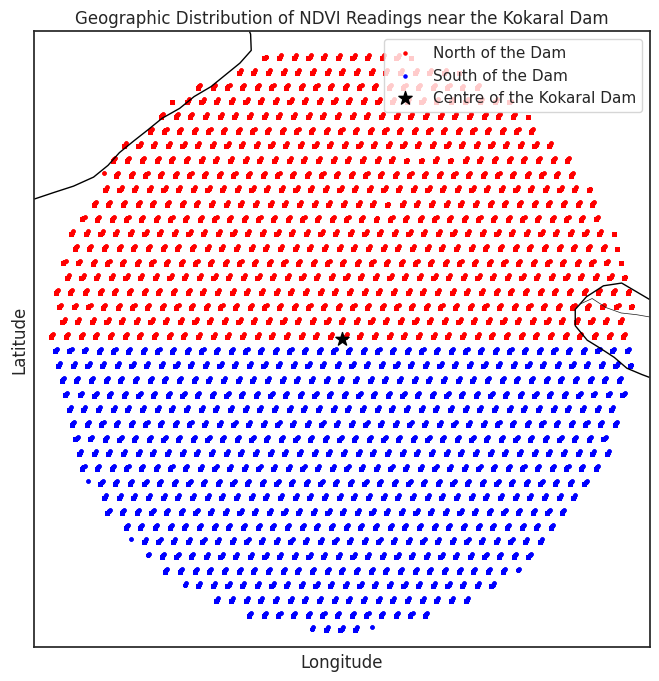

In [ ]:
map.drawcoastlines(color='black')
map.drawrivers()

map.scatter(x=df[df['Region']=='North']['Longitude'], y=df[df['Region']=='North']['Latitude'], s=15, c='red', label='North of the Dam', latlon=True)
map.scatter(x=df[df['Region']=='South']['Longitude'], y=df[df['Region']=='South']['Latitude'], s=15, c='blue', label='South of the Dam', latlon=True)
map.scatter(60.79306, 46.09667, s=100, c='black', marker='*', label='Centre of the Kokaral Dam', latlon=True)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographic Distribution of NDVI Readings near the Kokaral Dam")
matplotlib.pyplot.legend()

In [ ]:
print(min(df['NDVI']))

-0.2


In [ ]:
px.scatter_map(df, lat="Latitude", lon="Longitude", color="NDVI",
               color_continuous_scale=px.colors.sequential.Viridis, size_max=15, zoom=10,
               animation_frame=df["Date"].dt.year.astype(str),
               map_style="carto-positron")

Buffered data was truncated after reaching the output size limit.

# Difference in differences for yearly data

In [ ]:
df['Year'] = df['Date'].dt.year
yearly = df.groupby([df['Year'], df['Region']])['NDVI'].mean().reset_index()

,Year,Region,NDVI
0,2000,North,0.099166
1,2000,South,0.130259
2,2001,North,0.095629
3,2001,South,0.109718
4,2002,North,0.129399


In [ ]:
yearly['post']=np.where(yearly['Year']>2005,1,0)
yearly['treatment']=np.where(yearly['Region']=='North',1,0)
yearly['post_treatment']=yearly['post']*yearly['treatment']

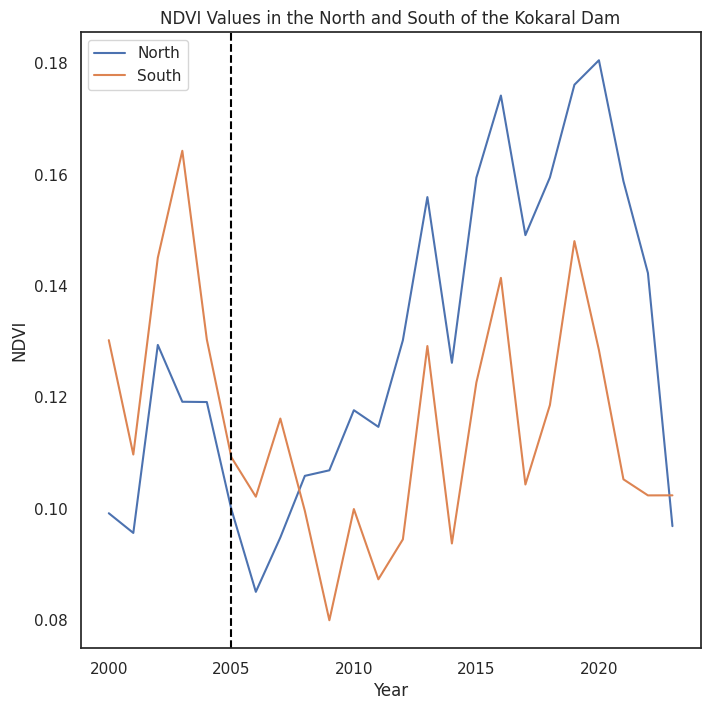

In [ ]:
sns.lineplot(data=yearly, x='Year', y='NDVI', hue='Region')
plt.title('NDVI Values in the North and South of the Kokaral Dam')
plt.axvline(x=2005, color='black', linestyle='--')
plt.legend()

In [ ]:
model = ols('NDVI ~ post + treatment + post_treatment', yearly).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   NDVI   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     4.257
Date:                Thu, 02 Jan 2025   Prob (F-statistic):             0.0100
Time:                        13:46:47   Log-Likelihood:                 113.56
No. Observations:                  48   AIC:                            -219.1
Df Residuals:                      44   BIC:                            -211.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1315      0.010     13.

# DiD for monthly data

In [ ]:
df['Month'] = df['Date'].dt.month
df['Month'] = (df['Year'] - 2000)*12 + df['Month']

monthly = df.groupby([df['Month'], df['Region']])['NDVI'].mean().reset_index()
monthly

,Month,Region,NDVI
0,2,North,-0.010715
1,2,South,-0.014682
2,3,North,0.053837
3,3,South,0.032789
4,4,North,0.097657
...,...,...,...
549,276,South,0.141347
550,277,North,0.123773
551,277,South,0.131525
552,278,North,0.046847


In [ ]:
monthly['post']=np.where(monthly['Month']>68,1,0)
monthly['treatment']=np.where(monthly['Region']=='North',1,0)
monthly['post_treatment']=monthly['post']*monthly['treatment']
monthly

,Month,Region,NDVI,post,treatment,post_treatment
0,2,North,-0.010715,0,1,0
1,2,South,-0.014682,0,0,0
2,3,North,0.053837,0,1,0
3,3,South,0.032789,0,0,0
4,4,North,0.097657,0,1,0
...,...,...,...,...,...,...
549,276,South,0.141347,1,0,0
550,277,North,0.123773,1,1,1
551,277,South,0.131525,1,0,0
552,278,North,0.046847,1,1,1


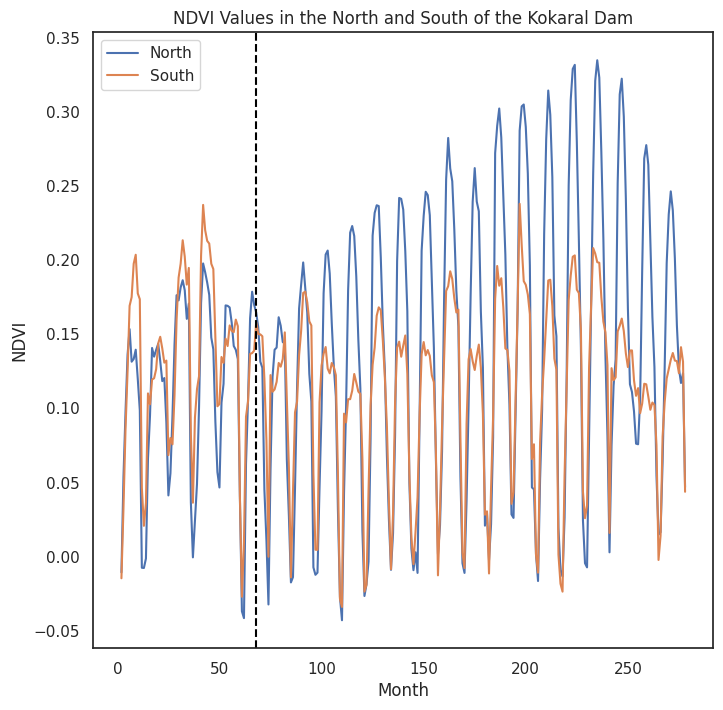

In [ ]:
sns.lineplot(data=monthly, x='Month', y='NDVI', hue='Region')
plt.title('NDVI Values in the North and South of the Kokaral Dam')
plt.axvline(x=68, color='black', linestyle='--')
plt.legend()

In [ ]:
model_monthly = ols('NDVI ~ post + treatment + post_treatment', monthly).fit()
print(model_monthly.summary())

                            OLS Regression Results                            
Dep. Variable:                   NDVI   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     5.856
Date:                Wed, 01 Jan 2025   Prob (F-statistic):           0.000610
Time:                        12:50:57   Log-Likelihood:                 629.30
No. Observations:                 554   AIC:                            -1251.
Df Residuals:                     550   BIC:                            -1233.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1310      0.010     13.